# Multi agent workflow

https://langchain-ai.github.io/langgraph/tutorials/

https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration/


In [1]:
#pip install pandas matplotlib langsmith

In [2]:
#pip install langgraph

In [6]:
%run utilities.ipynb

# Tavily Search tool

In [7]:
tavily_search = TavilyClient(api_key=tavily_api_key)
tavily_tool = TavilySearchResults(max_results=5)


# Serper Search Tool

In [8]:

serper_search = GoogleSerperAPIWrapper(gl="us")
@tool
def serper_tool1(query: str) -> str:
    """Look up things online."""
    name="Intermediate Answer",    
    answer=serper_search.results(query),
    description="useful for when you need to ask with search" 
    print("Inside serper_search_tool")
    return answer

serper_tool2 = load_tools(["google-serper"])

# Serper Dev

In [9]:
# from crewai_tools import DirectoryReadTool, \
#                          FileReadTool, \
#                          SerperDevTool,\
#                          ScrapeWebsiteTool
# scrape_tool=ScrapeWebsiteTool()
# import warnings
# warnings.filterwarnings('ignore')

# serperdev_tool = SerperDevTool(
#     search_url="https://google.serper.dev/scholar",
#     n_results=5,
# #    as_nlo=2014
# )

# Serpapi

In [10]:
import serpapi

serpapi_tool = load_tools(["serpapi"])

# Repl Python Code executor

In [11]:
repl = PythonREPL()
@tool
def python_repl1(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code. If you want to see the output of a value, you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Succesfully executed:\\\\n`python\\\\\\\\n{code}\\\\\\\\n`\\\\nStdout: {result}"

@tool
def python_repl2(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

# Initiate LLM and  tools and toolnodes

In [16]:
#llm= ChatOpenAI(model="gpt-3.5-turbo", temperature=0) 
llm= ChatOpenAI(model="gpt-3.5-turbo", temperature=0) 

search_tool=[tavily_tool] #[*serpapi_tool] #[tavily_tool] #[*serpapi_tool] #[tavily_tool] # [serper_tool2] #[serperdev_tool] # 
llm_with_search=llm.bind_tools(search_tool)
search_node = ToolNode(search_tool)

chart_tool=[python_repl2]
llm_with_chart=llm.bind_tools(chart_tool)
chart_node = ToolNode(chart_tool)


# One agent with Search Tool

In [17]:
class State(TypedDict):
    input: str
    messages: Annotated[list, add_messages]
    
def router(state: State):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        print("Using tools")
        return "calltool"
    return "end"

# Agent 1
def research_agent(state: State):
    messages = state["messages"]
    response =llm_with_search.invoke(messages)
    return {"messages": [response]}

# Agent2

search_node = ToolNode(search_tool)


# Exercise: Build a simple graph with one toolnode

Every agent and tool needs to be added via workflow.add_node("agent_name or tool_name",agent_routine or tool_routine)

workflow.set_entry_point("agent_name"): at what agent does the work flow start

workflow.add_edge("agent_name1","agent_name or tool_node"):to connect two agents or an agent and a tool


workflow.add_conditional_edges("agent_name",router,["toolname",END]): Look what the router returnsThe router either returns "calltool" or "end".

workflow.add_conditional_edges(
        "agent_name",
        router,
        {"Router Ausgabe1":"toolname","Router Aufgabe 2":END}
    )

If router returns "calltool" then the workflow proceeds to "toolname", of router returns "end", then end the workflow with the command END. 



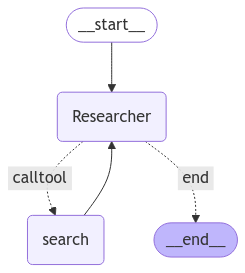

In [18]:
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("Researcher", research_agent)
workflow.add_node("search", search_node)

workflow.set_entry_point("Researcher")

workflow.add_conditional_edges("Researcher",router,{"calltool":"search","end":END})
workflow.add_edge("search","Researcher")

# Set up memory
memory = MemorySaver()

# Add
graph = workflow.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

# Solution


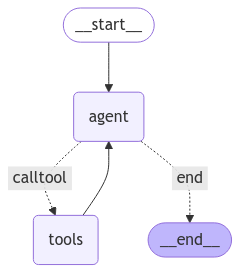

In [20]:
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", research_agent)
workflow.add_node("tools", search_node)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
        "agent",
        router,
        {"calltool":"tools","end":END}
    )
    
workflow.add_edge("tools", "agent")

# Set up memory
memory = MemorySaver()

# Add
graph = workflow.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
query="Fetch the GDP of Malysia over the last 5 years (from 2019 until 2023). Print the data using Markdown"
thread = {"configurable": {"thread_id": "1"}}
state=State()
state["messages"]=[query]
# Invoke the graph to process the user input
state = graph.invoke(state, thread)

Using tools


In [23]:
display(Markdown(state["messages"][-1].content))

### GDP of Malaysia Over the Last 5 Years:

- **2019:**
  - GDP: €326,169$365,178 million
  - GDP Growth Rate: 4.4%

- **2020:**
  - GDP: $337,456 million
  - GDP Growth Rate: -5.5%

- **2021:**
  - GDP: $373,785 million
  - GDP Growth Rate: 3.3%

- **2022:**
  - GDP: €386,768$407,606 million
  - GDP Growth Rate: 8.9%

- **2023:**
  - GDP: $399,705 million
  - GDP Growth Rate: 3.6%

Sources:
- [2019 GDP Source](https://countryeconomy.com/gdp/malaysia?year=2019)
- [2020 GDP Source](https://countryeconomy.com/gdp/malaysia?year=2020)
- [2021 GDP Source](https://countryeconomy.com/gdp/malaysia?year=2021)
- [2022 GDP Source](https://countryeconomy.com/gdp/malaysia?year=2022)
- [2023 GDP Source](https://countryeconomy.com/gdp/malaysia?year=2023)

# Research Agent with Search tool and Chart Agent with Chart tool

In [24]:

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]


def router2(state):
    print("router1")
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        print("router calls tool")
        return "call_tool"
    return "continue"

def router(state):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "call_tool"
    return "continue"

def research_agent(state):
    print("research_agent")
    result =llm_with_search.invoke(state["messages"])
    return {
        "messages": [result],
    }


def chart_agent(state):
    print("chart_agent")
    result =  llm_with_chart.invoke(state["messages"])
    return {
        "messages": [result],
    }
    



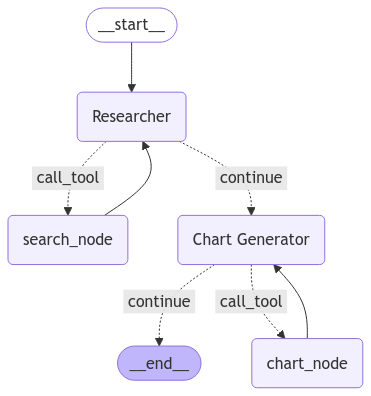

In [25]:
workflow= StateGraph(AgentState)
workflow.add_node("Researcher", research_agent)
workflow.add_node("search_node", search_node)
workflow.add_node("Chart Generator", chart_agent)
workflow.add_node("chart_node", chart_node)


workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "Chart Generator", "call_tool": "search_node"},
)
workflow.add_edge("search_node","Researcher")


workflow.add_conditional_edges(
    "Chart Generator",
    router,
    {"continue": END, "call_tool": "chart_node"},
)
workflow.add_edge("chart_node","Chart Generator")

workflow.set_entry_point("Researcher")
graph= workflow.compile(checkpointer=MemorySaver())
display(Image(graph.get_graph().draw_mermaid_png()))

research_agent
research_agent
chart_agent


Python REPL can execute arbitrary code. Use with caution.


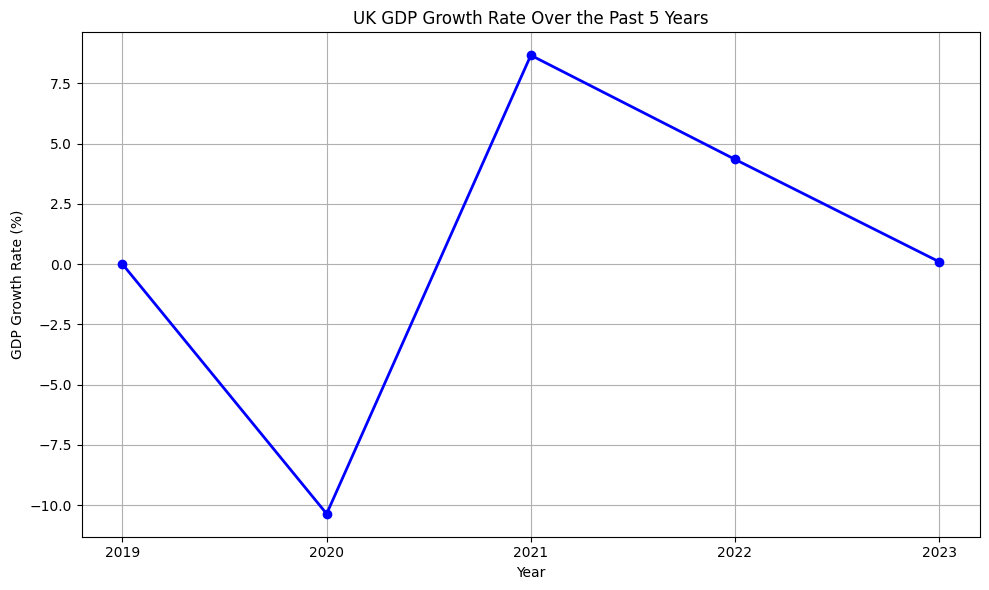

chart_agent


In [26]:
state=AgentState()
state["messages"]=[ ( "user",  "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",)]

       
thread = {"configurable": {"thread_id": "1"}}
state = graph.invoke(state,thread)

In [27]:
state["messages"]="The chart is still missing."
#state["messages"]="2019,2020,2021 are missing"

state = graph.invoke(state,thread)

research_agent
chart_agent


# Slight variation from the above using create_react_agent with added tools

In [35]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [36]:
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState
# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=search_tool,
    state_modifier=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def researcher(state: MessagesState) -> MessagesState:
    print("research_node")
    result = research_agent.invoke(state)
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        # share internal message history of research agent with other agents
        "messages": result["messages"],
    }


# Chart generator agent and node
chart_agent = create_react_agent(
    llm,
    tools=chart_tool,
    state_modifier=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)
def chart_generator(state: MessagesState) -> MessagesState:
    print("chart_node")
    result = chart_agent.invoke(state)
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return {
        # share internal message history of chart agent with other agents
        "messages": result["messages"],
    }
def router(state: MessagesState):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"    




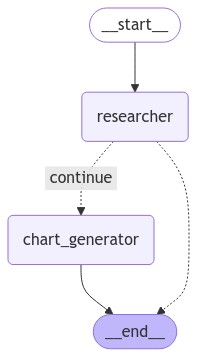

research_node
Inside serper_search_tool
Inside serper_search_toolInside serper_search_tool

chart_node


In [37]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", researcher)
workflow.add_node("chart_generator", chart_generator)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_edge("chart_generator", END)

workflow.add_edge(START, "researcher")
graph = workflow.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass
state= MessagesState()
state["messages"]=[ ( "user","First, get the Swiss wealth distribution,then make a chart of it. "
                "Once you make the chart, finish.",)]

       
thread = {"configurable": {"thread_id": "1"}}
state = graph.invoke(state,thread)    

# Exercise: Add an edge that leads back from the Chartnode to the researcher 

# Solution:

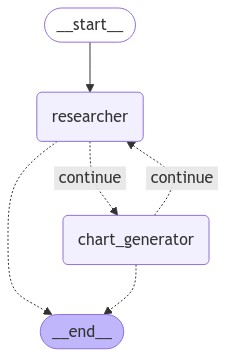

In [38]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", researcher)
workflow.add_node("chart_generator", chart_generator)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)

workflow.add_edge(START, "researcher")
graph = workflow.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    
    # This requires some extra dependencies and is optional
    pass

In [28]:
state= MessagesState()
state["messages"]=[ ( "user","First, get the Swiss wealth distribution,then make a chart of it. "
                       "Once you made the chart, finish.",)]

       
thread = {"configurable": {"thread_id": "1"}}
state = graph.invoke(state,thread)

research_agent
research_agent
research_agent
research_agent
research_agent
chart_agent
